0.24667070999999996 0.1420412881013273


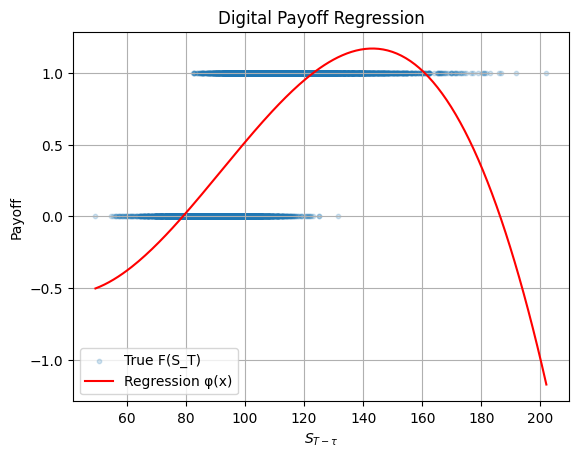

In [ ]:
############这一段是所有的代码，只run这一部分就行
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

class RNG:
    def __init__(self, seed=None):
        self.rng = np.random.default_rng()

    def normal(self, size, seed = 1):
        rng = np.random.default_rng(seed)
        return rng.standard_normal(size)
    

class Payoff:
    def __init__(self, strike, option_type='call'):
        self.strike = strike
        self.option_type = option_type

    def __call__(self, prices):
        if self.option_type == 'call':
            return np.maximum(prices - self.strike, 0)
        if self.option_type == 'put':
            return np.maximum(self.strike - prices, 0)
        if self.option_type == 'digital':
            return (prices > self.strike).astype(float)
        raise Exception("XXX")
        



class Market:
    def __init__(self, spot, r_t, sigma_t, times):
        self.spot = spot
        self.r_t = r_t
        self.sigma_t = sigma_t
        self.times = times

    




class PathGenerator:
    def __init__(self, market):
        self.spot = market.spot
        self.r_t = market.r_t
        self.sigma_t = market.sigma_t
        self.times = np.array(market.times)


# Monte carlo simulation of a path
    def generate_paths(self, N, random_matrix):
        M = len(self.times)
        paths = np.zeros((N, M))
        paths[:, 0] = self.spot
        for i in range(1, M):
            dt = self.times[i] - self.times[i - 1]
            r = self.r_t(self.times[i - 1])
            sigma = self.sigma_t(self.times[i - 1])
            paths[:, i] = paths[:, i - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * random_matrix[:, i - 1])
        return paths
    

def second_basis_function(x):
    return np.column_stack([np.ones_like(x), x, x**2, x**3])

def longstaff_regression(X, Y):
    Phi_x = second_basis_function(X)
    model = LinearRegression(fit_intercept = False)
    model.fit(Phi_x, Y)
    beta = model.coef_

    def phi(x_new):
        x_new = np.atleast_1d(x_new)
        return second_basis_function(x_new) @ beta
    
    return phi, beta






N = 10000
times = [0.0, 0.8, 1.0]
K = 100
market = Market(K, lambda t: 0.05, lambda t: 0.2, times)

# Setup
rng = RNG()
random_matrix = rng.normal(size=(N, len(times) - 1), seed = 34)
random_matrix_new = rng.normal(size = (N, len(times) - 1), seed = 3234)
payoff = Payoff(K, option_type='digital')
generator = PathGenerator(market)

# Simulate
paths = generator.generate_paths(N, random_matrix)
paths_new = generator.generate_paths(N, random_matrix_new)
X = paths[:, 1]  
X_new = paths_new[:, 1]
# S_{T - τ}

Y = payoff(paths[:, 2])  
# F(S_T)

phi, beta = longstaff_regression(X, Y)

#用回归得到的 phi(S_{T−τ}) 拟合 Y

Y_predicted = phi(X_new)

# 对比 variance
var_MC = np.var(Y)
var_LS = np.var(Y_predicted)

print(var_MC, var_LS)


plt.scatter(X, Y, alpha=0.2, label='True F(S_T)', s=10)
x_vals = np.linspace(min(X), max(X), 200)
plt.plot(x_vals, phi(x_vals), color='red', label='Regression φ(x)')
plt.xlabel('$S_{T−\\tau}$')
plt.ylabel('Payoff')
plt.title('Digital Payoff Regression')

plt.legend()
plt.grid(True)
plt.show()


上面是完整的代码
--------------------------------------------------------------------------------------------------------------
下面是草稿


In [103]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

class RNG:
    def __init__(self, seed=None):
        self.rng = np.random.default_rng()

    def normal(self, size, seed = 1):
        rng = np.random.default_rng(seed)
        return rng.standard_normal(size)
    

rng = RNG()
print(rng.normal(size=(2,2)))
print('11')
print(rng.normal(2))

[[ 0.34558419  0.82161814]
 [ 0.33043708 -1.30315723]]
11
[0.34558419 0.82161814]


Class payoff

In [104]:
class Payoff:
    def __init__(self, strike, option_type='call'):
        self.strike = strike
        self.option_type = option_type

    def __call__(self, prices):
        if self.option_type == 'call':
            return np.maximum(prices - self.strike, 0)
        if self.option_type == 'put':
            return np.maximum(self.strike - prices, 0)
        if self.option_type == 'digital':
            return (prices > self.strike).astype(float)
        raise Exception("XXX")
        

            

#set option type
        



Geometric Brownian Motion

In [105]:
class PathGenerator:
    def __init__(self, spot, r_t, sigma_t, times, rng):
        self.spot = spot
        self.r_t = r_t
        self.sigma_t = sigma_t
        self.times = np.array(times)
        self.rng = rng

# Monte carlo simulation of a path
    def generate_paths(self, N, random_matrix):
        M = len(self.times)
        paths = np.zeros((N, M))
        paths[:, 0] = self.spot
        for i in range(1, M):
            dt = self.times[i] - self.times[i - 1]
            r = self.r_t(self.times[i - 1])
            sigma = self.sigma_t(self.times[i - 1])
            paths[:, i] = paths[:, i - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * random_matrix[:, i - 1])
        return paths

Implement

Longstaff–Schwartz Regression

In [ ]:
def basis_functions(x):
    return np.column_stack([
        # Polynomial 1, x , x^2
        np.ones_like(x),  
        x,                
        x**2,
        x**3           
    ])

def ls_regression(X, Y):
    #X = S_{T - τ}
    #Y = F(S_T)
    Phi_X = basis_functions(X)
    model = LinearRegression(fit_intercept=False)
    model.fit(Phi_X, Y)
    beta = model.coef_
    
    def phi(x_new):
        x_new = np.atleast_1d(x_new)
        return basis_functions(x_new) @ beta

    return phi, beta

def second_basis_function(x):
    return np.column_stack([np.ones_like(x), x, x**2, x**3])

def longstaff_regression(X, Y):
    Phi_x = second_basis_function(X)
    model = LinearRegression(fit_intercept = False)
    model.fit(Phi_x, Y)
    beta = model.coef_

    def phi(x_new):
        x_new = np.atleast_1d(x_new)
        return second_basis_function(x_new) @ beta
    
    return phi, beta











In [ ]:

#main
# Parameters

spot = 100
K = 100
# T = 1.0
times = [0.0, 0.8, 1.0]  
# t0, t_{T-τ}, T

r_t = lambda t: 0.05
sigma_t = lambda t: 0.2
N = 10000
#simulate S_{T-τ} and F(S_T) for regression



# Setup
rng = RNG(seed=6)
random_matrix = rng.normal(size=(N, len(times) - 1), seed = 3)
payoff = Payoff(K, option_type='digital')
generator = PathGenerator(spot, r_t, sigma_t, times, random_matrix)

# Simulate
paths = generator.generate_paths(N, random_matrix)
X = paths[:, 1]  
# S_{T - τ}

Y = payoff(paths[:, 2])  
# F(S_T)

phi, beta = ls_regression(X, Y)

#用回归得到的 phi(S_{T−τ}) 拟合 Y
#这里还是用的原来的X来predict的Y 
Y_predicted = phi(X)

# 对比 variance
var_MC = np.var(Y)
var_LS = np.var(Y_predicted)

print(var_MC, var_LS)

0.24609375 0.13259453114688455


把digital payoff 带入到regression框架中

MC variance (no regression): 0.24643137135600002
Regression variance: 0.1298751000936685


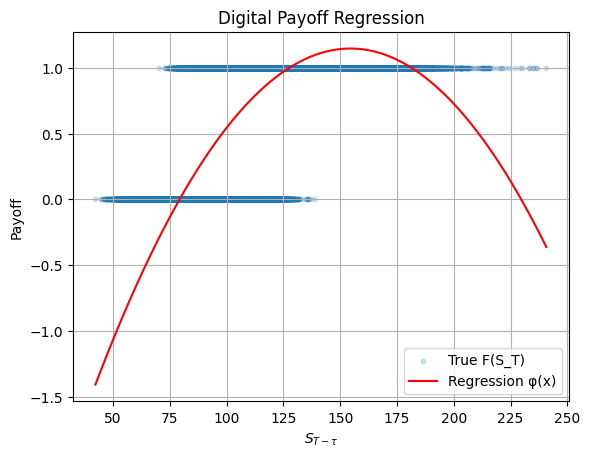

In [62]:
K = 100  # strike
payoff = Payoff(K, option_type='digital')  # step payoff: 1 if S_T > K, else 0
# times: [0, T−τ, T]
paths = generator.generate_paths(N)

X = paths[:, 1]  # S_{T−τ}
S_T = paths[:, 2]
Y = payoff(S_T)  # digital payoff

# Perform regression and get coefficients
phi_fn, coeffs = ls_regression(X, Y)

Y_pred = phi(X)

# Compare variances
var_mc = np.var(Y)              # Monte Carlo (原始 F(S_T))
var_phi = np.var(Y_pred)        # Regression 后的 phi(S_{T−τ})

print("MC variance (no regression):", var_mc)
print("Regression variance:", var_phi)



plt.scatter(X, Y, alpha=0.2, label='True F(S_T)', s=10)
x_vals = np.linspace(min(X), max(X), 200)
plt.plot(x_vals, phi_fn(x_vals), color='red', label='Regression φ(x)')
plt.xlabel('$S_{T−\\tau}$')
plt.ylabel('Payoff')
plt.title('Digital Payoff Regression')
plt.legend()
plt.grid(True)
plt.show()